In [1]:
# Initialization boilerplate
from typing import *

import os
import ibm_watson
import ibm_watson.natural_language_understanding_v1 as nlu
import ibm_cloud_sdk_core
import pandas as pd
import text_extensions_for_pandas as tp
import urllib

import ray
import spacy
import multiprocessing
import time
import threading
import matplotlib.pyplot as plt

# Remove silly SpaCy warnings about not having a GPU
def fix_spacy_warnings():
    import warnings
    warnings.filterwarnings(action='ignore', \
        category=UserWarning, message='.*User provided device_type.*')
fix_spacy_warnings()

# Remove silly Huggingface warnings about not using a useless parallel tokenizer.
os.environ["TOKENIZERS_PARALLELISM"] = "false"

api_key = os.environ.get("IBM_API_KEY")
service_url = os.environ.get("IBM_SERVICE_URL")  

# Part 5: Scale up some more with Pandas and Ray

Let's start by summarizing our progress so far.

In [Part 1](./Market_Intelligence_Part1.ipynb), we defined an NLP pipeline that used Watson Natural Language Understanding and Text Extensions for Pandas to identify the names of executives in corporate press releases.

In [Part 2](./Market_Intelligence_Part2.ipynb), we extended our NLP pipeline by using SpaCy and Text Extensions for Pandas to associate each executive name with a job title.

If we separate the expensive NLP model evaluations from the rest of our code, we can think of this processing pipeline as having five distinct stages, as shown in the following diagram.

![First version of our processing pipeline](images/pipeline_v1.png)

In [Part 3](./Market_Intelligence_Part3.ipynb), we applied the semijoin trick with Text Extensions for Pandas to reduce the cost of running the SpaCy dependency parser. This change decreased the cost of parsing by a factor of 9 and improved end-to-end running time by a factor of 3.

In [Part 4](./Market_Intelligence_Part4.ipynb), we showed how you can use [Ray](ray.io) to rate-limit requests to a remote web service such as Watson Natural Language Understanding.

In this final part of the tutorial, we use Ray to take the performance improvements from Part 3 to the next level by applying parallel processing. By the time we're done, we'll have a version of our pipeline that runs **300 times faster** than the pipeline we started with at the beginning of Part 3.



In [2]:
import market_intelligence as mi
articles = mi.maybe_download_articles()
articles

,url,html
0,https://newsroom.ibm.com/2020-02-04-The-Avril-...,"<!DOCTYPE html public ""-//W3C//DTD HTML 4.01 T..."
1,https://newsroom.ibm.com/2020-02-11-IBM-X-Forc...,"<!DOCTYPE html public ""-//W3C//DTD HTML 4.01 T..."
2,https://newsroom.ibm.com/2020-02-18-IBM-Study-...,"<!DOCTYPE html public ""-//W3C//DTD HTML 4.01 T..."
3,https://newsroom.ibm.com/2020-02-19-IBM-Power-...,"<!DOCTYPE html public ""-//W3C//DTD HTML 4.01 T..."
4,https://newsroom.ibm.com/2020-02-20-Centotrent...,"<!DOCTYPE html public ""-//W3C//DTD HTML 4.01 T..."
...,...,...
186,https://newsroom.ibm.com/2021-01-25-OVHcloud-t...,"<!DOCTYPE html public ""-//W3C//DTD HTML 4.01 T..."
187,https://newsroom.ibm.com/2021-01-26-Luminor-Ba...,"<!DOCTYPE html public ""-//W3C//DTD HTML 4.01 T..."
188,https://newsroom.ibm.com/2021-01-26-DIA-Levera...,"<!DOCTYPE html public ""-//W3C//DTD HTML 4.01 T..."
189,https://newsroom.ibm.com/2021-01-26-IBM-Board-...,"<!DOCTYPE html public ""-//W3C//DTD HTML 4.01 T..."


## Baseline: Process documents with a simple `for` loop.

Parts 1 and 2 of this tutorial defined a processing pipeline with two parts: First find places where the document quotes a person by name, then associate those names with job titles. 

If we break out the expensive model evaluations from these two parts, we get a four-step pipeline. Tack on the final step of merging these results across our entire collection of documents, and you will have five steps.

Here we have a version of the code from the end of Part 2, refactored slightly to break out those five distinct steps. Let's see how long it takes to run through our collection of 191 IBM press releases.

In [3]:
# The functions we call here are in the companion Python file market_intelligence.py
import market_intelligence as mi

In [4]:
%%time

spacy_language_model = spacy.load("en_core_web_trf")
nlu_api = ibm_watson.NaturalLanguageUnderstandingV1(version="2021-01-01", 
            authenticator=ibm_cloud_sdk_core.authenticators.IAMAuthenticator(api_key))
nlu_api.set_service_url(service_url)

def steps_1_through_4(doc_html: str) -> pd.DataFrame:
    # Steps 1 and 2, as implemented in find_persons_quoted_by_name()
    step_1_results = mi.extract_named_entities_and_semantic_roles(doc_html, nlu_api)
    step_2_results = mi.identify_persons_quoted_by_name(step_1_results)   
    
     # Steps 3 and 4, as implemented in find_titles_of_persons()
    step_3_results = mi.perform_dependency_parsing(step_1_results["analyzed_text"],
                                                   spacy_language_model)
    step_4_results = mi.extract_titles_of_persons(step_2_results, step_3_results)
    return step_4_results

# Repeat steps 1-4 on every document
dataframes_to_stack = [
    steps_1_through_4(doc_html) for doc_html in articles["html"]
]

# Step 5: Merge the results across documents
step_5_results = pd.concat(dataframes_to_stack)
step_5_results

CPU times: user 14min 50s, sys: 36.5 s, total: 15min 27s
Wall time: 18min 11s


,person,title
0,"[1977, 1991): 'Wendi Whitmore'","[1993, 2040): 'Vice President, IBM X-Force Thr..."
0,"[1281, 1292): 'Rob DiCicco'","[1294, 1348): 'PharmD, Deputy Chief Health Off..."
0,"[1213, 1229): 'Christoph Herman'","[1231, 1281): 'SVP and Head of SAP HANA Enterp..."
1,"[2227, 2242): 'Stephen Leonard'","[2244, 2282): 'General Manager, IBM Cognitive ..."
0,"[2290, 2298): 'Bob Lord'","[2300, 2376): 'IBM Senior Vice President of Co..."
...,...,...
0,"[3113, 3123): 'Mike Doran'","[3125, 3156): 'Worldwide Sales Director at IBM'"
0,"[3156, 3170): 'Howard Boville'","[3172, 3211): 'Senior Vice President, IBM Hybr..."
0,"[3116, 3139): 'Samuel Brack Co-Founder'","[3129, 3154): 'Co-Founder and CTO at DIA'"
1,"[3511, 3525): 'Hillery Hunter'","[3527, 3558): 'IBM Fellow, VP & CTO, IBM Cloud'"


The exact running time for the above cell varies depending on which machine you use to run the notebook and what other processes are running in the background. On a 2020 Macbook Pro, it takes around 850 seconds. Let's see if we can improve on that running time.

## Recap: Accelerating the baseline pipeline with the semijoin trick

In Part 3, we showed how to improve the end-to-end performance of this pipeline by applying the semijoin trick to the expensive dependency parsing step. This change made parsing 9x faster, improving the end-to-end performance by a factor of 3. Here's what our five-stage pipeline looks like after that change.

In [5]:
%%time

spacy_language_model = spacy.load("en_core_web_trf")
nlu_api = ibm_watson.NaturalLanguageUnderstandingV1(version="2021-01-01", 
            authenticator=ibm_cloud_sdk_core.authenticators.IAMAuthenticator(api_key))
nlu_api.set_service_url(service_url)

def steps_1_through_4(doc_html: str) -> pd.DataFrame:
    # Steps 1 and 2, as implemented in find_persons_quoted_by_name()
    step_1_results = mi.extract_named_entities_and_semantic_roles(doc_html, nlu_api)
    step_2_results = mi.identify_persons_quoted_by_name(step_1_results)   
    
     # Steps 3 and 4, as implemented in find_titles_of_persons()
    step_3_results = mi.perform_targeted_dependency_parsing(
                                                   step_2_results["person"],
                                                   spacy_language_model)
    step_4_results = mi.extract_titles_of_persons(step_2_results, step_3_results)
    return step_4_results

# Repeat steps 1-4 on every document
dataframes_to_stack = [
    steps_1_through_4(doc_html) for doc_html in articles["html"]
]

# Step 5: Merge the results across documents
step_5_results = pd.concat(dataframes_to_stack)
step_5_results

CPU times: user 1min 52s, sys: 3.12 s, total: 1min 55s
Wall time: 4min 23s


,person,title
0,"[1977, 1991): 'Wendi Whitmore'","[1993, 2040): 'Vice President, IBM X-Force Thr..."
0,"[1281, 1292): 'Rob DiCicco'","[1294, 1348): 'PharmD, Deputy Chief Health Off..."
0,"[1213, 1229): 'Christoph Herman'","[1231, 1281): 'SVP and Head of SAP HANA Enterp..."
1,"[2227, 2242): 'Stephen Leonard'","[2244, 2282): 'General Manager, IBM Cognitive ..."
0,"[2290, 2298): 'Bob Lord'","[2300, 2376): 'IBM Senior Vice President of Co..."
...,...,...
0,"[3113, 3123): 'Mike Doran'","[3125, 3156): 'Worldwide Sales Director at IBM'"
0,"[3156, 3170): 'Howard Boville'","[3172, 3211): 'Senior Vice President, IBM Hybr..."
0,"[3116, 3139): 'Samuel Brack Co-Founder'","[3131, 3154): '-Founder and CTO at DIA'"
1,"[3511, 3525): 'Hillery Hunter'","[3527, 3558): 'IBM Fellow, VP & CTO, IBM Cloud'"


This code runs in about 280 seconds, a 3x improvement from the initial baseline version.

Now it's time to deploy parallel processing and improve that performance some more.

## First version: Wrap the entire processing pipeline in a `@ray.remote` decorator.

[Ray](https://ray.io) is a system for parallel processing that is designed to work at a wide variety of scales. As you tune the accuracy of an NLP application, you'll move between different sized inputs. You may start out by examining results on individual documents on your laptop, then switch to processing dozens of documents on your laptop. Later you may run 
through thousands of documents on a server. Eventually, you could deploy to production and process millions of documents on a cluster. And when there's a problem in production you might find yourself back again to working on your laptop for the next round of tuning.

Ray lets you code up your processing pipeline once and have it work well across this wide variety of scales. That way you can use the same code at every point throughout this iterative process.

In the remainder of this part of the tutorial, we're going to show how to parallelize our end-to-end pipeline using Ray. Once we have it running in parallel on a laptop, we'll take the same code over to a large server to get even more parallel speedup.

The first step is to start up a Ray cluster by calling `ray.init()`.

In [6]:
def reboot_ray():
    if ray.is_initialized():
        ray.shutdown()
    ray.init()
    
reboot_ray()

2022-04-16 14:15:07,175	INFO services.py:1374 -- View the Ray dashboard at http://127.0.0.1:8265


Now let's try the simplest approach possible: Wrap our document processing code in a Ray remote function. To create a remote function, we just need to define a Python function and add the `@ray.remote` decorator to the function:

In [7]:
# NOTE: The blog version of this cell should show this code side-by-side with the 
#  original code and highlight the changes.

spacy_language_model = spacy.load("en_core_web_trf")
nlu_api = ibm_watson.NaturalLanguageUnderstandingV1(version="2021-01-01", 
            authenticator=ibm_cloud_sdk_core.authenticators.IAMAuthenticator(api_key))
nlu_api.set_service_url(service_url)

# @ray.remote decorator defines a Ray task
@ray.remote
def steps_1_through_4(doc_html: str) -> pd.DataFrame:
    step_1_results = mi.extract_named_entities_and_semantic_roles(doc_html, nlu_api)
    step_2_results = mi.identify_persons_quoted_by_name(step_1_results)   
    step_3_results = mi.perform_targeted_dependency_parsing(
                                                   step_2_results["person"],
                                                   spacy_language_model)
    step_4_results = mi.extract_titles_of_persons(step_2_results, step_3_results)
    return step_4_results



Now we can push the processing of a document to the Ray cluster by spawning a copy of the remote function. To spawn a copy of the function, we call the remote function's `remote()` method, which starts running the function in the background and returns a *future* -- a placeholder for the result that the function will produce when it completes.

If we pass the future to `ray.get()`, then Ray will block until the function has completed, download the result to the calling process, and return the result:

In [8]:
doc_html = articles.iloc[1]["html"]

future = steps_1_through_4.remote(doc_html)
step_4_results = ray.get(future)

TypeError: Could not serialize the function 1686926749.steps_1_through_4. Check https://docs.ray.io/en/master/serialization.html#troubleshooting for more information.

Oops, that didn't work! Ray tasks can only operate over Python objects that can be serialized. A connection to Watson NLU can't be serialized because the connection object has open sockets and lock objects

We also can't serialize the language model inside the SpaCy dependency parser (as of SpaCy version 3.0), because that Python object contains locks. Even if you could serialize it, doing so would result in Ray shipping a 500 megabyte model to every copy of the task, which would lead to underwhelming performance.

To make this work, we'll need to pull the initialization code for both models inside the Ray task:

In [9]:
@ray.remote
def steps_1_through_4(doc_html: str) -> pd.DataFrame:
    fix_spacy_warnings()  # Workaround for spurious warning messages
    spacy_language_model = spacy.load("en_core_web_trf")
    nlu_api = ibm_watson.NaturalLanguageUnderstandingV1(version="2021-01-01", 
            authenticator=ibm_cloud_sdk_core.authenticators.IAMAuthenticator(api_key))
    nlu_api.set_service_url(service_url)
    
    step_1_results = mi.extract_named_entities_and_semantic_roles(doc_html, nlu_api)
    step_2_results = mi.identify_persons_quoted_by_name(step_1_results)   
    step_3_results = mi.perform_targeted_dependency_parsing(
                                                   step_2_results["person"],
                                                   spacy_language_model)
    step_4_results = mi.extract_titles_of_persons(step_2_results, step_3_results)
    return step_4_results


Now our Ray task works on a single document:

In [10]:
step_4_results = ray.get(steps_1_through_4.remote(doc_html))
step_4_results

,person,title
0,"[1977, 1991): 'Wendi Whitmore'","[1993, 2040): 'Vice President, IBM X-Force Thr..."


To process our entire collection of documents, we modify our `for` loop so that it spawns background tasks for each of the documents instead of processing the documents locally. Then we wrap the `for` loop in a call to `ray.get()`, which tells Ray to wait until all the background tasks have completed and collect the results:

In [11]:
# Don't include this cell in the blog
reboot_ray()

2022-04-16 14:27:28,089	INFO services.py:1374 -- View the Ray dashboard at http://127.0.0.1:8265


In [12]:
%%time

# NOTE: The blog version of this listing should highlight what has changed 
#  relative to the original code.

@ray.remote
def steps_1_through_4(doc_html: str) -> pd.DataFrame:
    fix_spacy_warnings()  # Workaround for spurious warning messages
    nlu_api = ibm_watson.NaturalLanguageUnderstandingV1(version="2021-01-01", 
            authenticator=ibm_cloud_sdk_core.authenticators.IAMAuthenticator(api_key))
    nlu_api.set_service_url(service_url)
    spacy_language_model = spacy.load("en_core_web_trf")
    
    step_1_results = mi.extract_named_entities_and_semantic_roles(doc_html, nlu_api)
    step_2_results = mi.identify_persons_quoted_by_name(step_1_results)   
    step_3_results = mi.perform_targeted_dependency_parsing(
                                                   step_2_results["person"],
                                                   spacy_language_model)
    step_4_results = mi.extract_titles_of_persons(step_2_results, step_3_results)
    return step_4_results

# Repeat steps 1-4 on every document, at the same time
dataframes_to_stack = ray.get([
    steps_1_through_4.remote(doc_html) for doc_html in articles["html"]
])

# Step 5: Merge the results across documents
step_5_results = pd.concat(dataframes_to_stack)
step_5_results

(steps_1_through_4 pid=69306) Request failed 1 times; retrying in 1 sec
(steps_1_through_4 pid=69317) Request failed 1 times; retrying in 1 sec
(steps_1_through_4 pid=69307) Request failed 1 times; retrying in 1 sec
(steps_1_through_4 pid=69312) Request failed 1 times; retrying in 1 sec
(steps_1_through_4 pid=69313) Request failed 1 times; retrying in 1 sec
(steps_1_through_4 pid=69304) Request failed 1 times; retrying in 1 sec
(steps_1_through_4 pid=69315) Request failed 1 times; retrying in 1 sec
(steps_1_through_4 pid=69314) Request failed 1 times; retrying in 1 sec
(steps_1_through_4 pid=69304) Request failed 2 times; retrying in 2 sec
(steps_1_through_4 pid=69315) Request failed 2 times; retrying in 2 sec
(steps_1_through_4 pid=69310) Request failed 1 times; retrying in 1 sec
(steps_1_through_4 pid=69314) Request failed 1 times; retrying in 1 sec
(steps_1_through_4 pid=69310) Request failed 1 times; retrying in 1 sec
CPU times: user 3.04 s, sys: 1.17 s, total: 4.22 s
Wall time: 1m

,person,title
0,"[1977, 1991): 'Wendi Whitmore'","[1993, 2040): 'Vice President, IBM X-Force Thr..."
0,"[1281, 1292): 'Rob DiCicco'","[1294, 1348): 'PharmD, Deputy Chief Health Off..."
0,"[1213, 1229): 'Christoph Herman'","[1231, 1281): 'SVP and Head of SAP HANA Enterp..."
1,"[2227, 2242): 'Stephen Leonard'","[2244, 2282): 'General Manager, IBM Cognitive ..."
0,"[2290, 2298): 'Bob Lord'","[2300, 2376): 'IBM Senior Vice President of Co..."
...,...,...
0,"[3113, 3123): 'Mike Doran'","[3125, 3156): 'Worldwide Sales Director at IBM'"
0,"[3156, 3170): 'Howard Boville'","[3172, 3211): 'Senior Vice President, IBM Hybr..."
0,"[3116, 3139): 'Samuel Brack Co-Founder'","[3131, 3154): '-Founder and CTO at DIA'"
1,"[3511, 3525): 'Hillery Hunter'","[3527, 3558): 'IBM Fellow, VP & CTO, IBM Cloud'"


This version runs correctly, and it runs in about 90 seconds on our 8-core laptop -- an additional performance improvement of almost 3x on top of the 3x improvement from Part 3.

But there's room for two kinds of additional improvement:
* This code loads a 500 megabyte model for every document, which incurs a signficant additional cost. The 8 cores on our test machine are fully occupied, but we only see a speedup of 3. So we're using more than twice as many CPU cycles per document.
* This code produces several screens of scary log messages like: 
  ```
  (pid=8210) Request failed 2 times; retrying in 2 sec
  ```
  because we're exceeding the request rate limit of our free Lite instance of Watson Natural Language Understanding. The limit for a Lite instance is 5 requests per second.
  We should be able to finish our 190 documents in 38 seconds while staying below the limit.
  But instead we're taking twice as long while continually bumping up against the limit and having to retry requests.
  
We can use Ray *actors* to address both of these problems.

## Using actors to avoid repeated model startup

A Ray *actor* is persistent Python or Java object that lives in a Ray worker process. Actors can maintain arbitrary amounts of state, both mutable and immutable. If we attach the SpaCy language model to an actor, then the model will be initialized once in the actor's constructor instead of being loaded each time we process a document.

Turning our `steps_1_through_4()` function into a Ray Actor is a simple matter of restructuring the code slightly.

Here's the code before using actor:
```python
@ray.remote
def steps_1_through_4(doc_html: str) -> pd.DataFrame:
    spacy_language_model = spacy.load("en_core_web_trf")
    nlu_api = ibm_watson.NaturalLanguageUnderstandingV1(version="2021-01-01", 
            authenticator=ibm_cloud_sdk_core.authenticators.IAMAuthenticator(api_key))
    nlu_api.set_service_url(service_url)
    
    step_1_results = mi.extract_named_entities_and_semantic_roles(doc_html, nlu_api)
    step_2_results = mi.identify_persons_quoted_by_name(step_1_results)   
    step_3_results = mi.perform_targeted_dependency_parsing(
                                                   step_1_results["analyzed_text"],
                                                   spacy_language_model)
    step_4_results = mi.extract_titles_of_persons(step_2_results, step_3_results)
    return step_4_results
```

And here's a version that uses an actor:

In [13]:
@ray.remote
class ParserModelActor(object):
    def __init__(self, spacy_model_name: str):
        self._language_model = spacy.load(spacy_model_name)
        self._nlu_api = ibm_watson.NaturalLanguageUnderstandingV1(version="2021-01-01", 
                authenticator=ibm_cloud_sdk_core.authenticators.IAMAuthenticator(api_key))
        self._nlu_api.set_service_url(service_url)

    def steps_1_through_4(self, doc_html: str) -> pd.DataFrame:
        fix_spacy_warnings()  # Workaround for spurious warning messages
        step_1_results = mi.extract_named_entities_and_semantic_roles(doc_html, 
                                                                      self._nlu_api)
        step_2_results = mi.identify_persons_quoted_by_name(step_1_results)   
        step_3_results = mi.perform_targeted_dependency_parsing(
                                                       step_2_results["person"],
                                                       self._language_model)
        step_4_results = mi.extract_titles_of_persons(step_2_results, step_3_results)
        return step_4_results


Compared with the previous Ray task, this version makes two important changes:
* The model initializaiton in first line of `steps_1_through_4` moves to the class's constructor.
* We use the actor's local copy, `self._language_model`, as the input to the processing for step 3.

Invoking a Ray actor is a two-step process. First, you create an instance of the actor. Then you tell that instance to perform tasks.

Here's some code that creates an instance of the `ParserModelActor` Actor, invokes the actor's `steps_1_through_4` task, blocks until the task completes, and returns the results:

In [14]:
# Don't include this cell in the blog
reboot_ray()

2022-04-16 14:29:03,824	INFO services.py:1374 -- View the Ray dashboard at http://127.0.0.1:8265


In [15]:
actor = ParserModelActor.remote("en_core_web_trf")
future = actor.steps_1_through_4.remote(doc_html)
step_4_results = ray.get(future)
step_4_results

,person,title
0,"[1977, 1991): 'Wendi Whitmore'","[1993, 2040): 'Vice President, IBM X-Force Thr..."


This code runs, performs the computation in the background, and produces the correct result. And the actor will remain active as long as the Python variable `actor` is still in scope. We can pass additional documents to the `steps_1_through_4` task without incurring the overhead of loading a language model each time.

As a Python class, this actor can only process one request at a time. To process documents in parallel, we can define a Ray [actor pool](https://docs.ray.io/en/latest/ray-core/actors/actor-utils.html#actor-pool), a group of multiple copies of our actor that can process documents in parallel.

In [16]:
# Don't include this cell in the blog
reboot_ray()

2022-04-16 14:29:20,386	INFO services.py:1374 -- View the Ray dashboard at http://127.0.0.1:8265


In [17]:
%%time

# This listing should NOT appear in the blog version.
# Run a pool with the actor defined above over the entire document collection, just
# to make sure it works and to determine the running time.

num_cpus = multiprocessing.cpu_count() // 2

actors = ray.util.ActorPool([ParserModelActor.remote("en_core_web_trf")
                             for i in range(num_cpus)])

# Repeat steps 1-4 on every document
dataframes_to_stack = actors.map_unordered(
    lambda actor, value: actor.steps_1_through_4.remote(value), articles["html"]
)

# Step 5: Merge the results across documents
step_5_results = pd.concat(dataframes_to_stack)
step_5_results

(ParserModelActor pid=69429) Request failed 1 times; retrying in 1 sec
(ParserModelActor pid=69440) Request failed 1 times; retrying in 1 sec
(ParserModelActor pid=69434) Request failed 1 times; retrying in 1 sec
(ParserModelActor pid=69440) Request failed 1 times; retrying in 1 sec
(ParserModelActor pid=69429) Request failed 1 times; retrying in 1 sec
(ParserModelActor pid=69440) Request failed 1 times; retrying in 1 sec
(ParserModelActor pid=69443) Request failed 1 times; retrying in 1 sec
(ParserModelActor pid=69440) Request failed 2 times; retrying in 2 sec
(ParserModelActor pid=69441) Request failed 1 times; retrying in 1 sec
(ParserModelActor pid=69440) Request failed 1 times; retrying in 1 sec
(ParserModelActor pid=69437) Request failed 1 times; retrying in 1 sec
(ParserModelActor pid=69443) Request failed 1 times; retrying in 1 sec
(ParserModelActor pid=69429) Request failed 1 times; retrying in 1 sec
(ParserModelActor pid=69437) Request failed 1 times; retrying in 1 sec
(Parse

,person,title
0,"[1289, 1303): 'Wendi Whitmore'","[1305, 1344): 'VP of Threat Intelligence, IBM ..."
0,"[1977, 1991): 'Wendi Whitmore'","[1993, 2040): 'Vice President, IBM X-Force Thr..."
0,"[1213, 1229): 'Christoph Herman'","[1231, 1281): 'SVP and Head of SAP HANA Enterp..."
1,"[2227, 2242): 'Stephen Leonard'","[2244, 2282): 'General Manager, IBM Cognitive ..."
0,"[2290, 2298): 'Bob Lord'","[2300, 2376): 'IBM Senior Vice President of Co..."
...,...,...
1,"[2119, 2134): 'James Kavanaugh'","[2136, 2189): 'IBM senior vice president and c..."
0,"[3116, 3139): 'Samuel Brack Co-Founder'","[3131, 3154): '-Founder and CTO at DIA'"
1,"[3511, 3525): 'Hillery Hunter'","[3527, 3558): 'IBM Fellow, VP & CTO, IBM Cloud'"
0,"[1488, 1498): 'Ana Zamper'","[1500, 1535): 'Ecosystem Leader, IBM Latin Ame..."


## Using actors to manage request rate

The large model that we attached to our `ParserModelActor` actor is an example of *immutable* actor state. Ray actors can also have *mutable* state that changes in response to tasks that the actor performs.

For this application, we can use mutable actor state to track of how quickly our application is sending requests to the Watson Natural Language Understanding web service. 

Part 4 of this tutorial described in detail how to add such rate-limiting logic with a Ray actor. Here's a quick summary of how it works: We track the request rate is by tracking how much time has elapsed since the most recent request. With that information in hand, our actor can throttle new requests if they would exceed the rate limit. We put the logic for managing this state into an abstract base class, `RateLimitedActor`, the code for which can be found in `market_intelligence.py`. With that base class in place, we can define a Ray actor that sends documents to the Watson Natural Language Understanding web service while respecting a request rate limit. Because the Python API for Watson Natural Language Understanding is thread-safe, we can use a multithreaded Python actor to track multiple simulataneous requests.

In [18]:
@ray.remote
class NLUClientActor(mi.RateLimitedActor):
    """
    Threaded actor to handle multiple simulatenous requests to the IBM Watson
    Natural Language Understanding service while respecting an upper bound on the
    number of requests per second.
    """
    def __init__(self, requests_per_sec: float, 
                 api_key: str, service_url: str):
        super().__init__(requests_per_sec)
        # One instance of the Python API for all threads
        self._nlu_api = ibm_watson.NaturalLanguageUnderstandingV1(
            version="2021-01-01", 
            authenticator=ibm_cloud_sdk_core.authenticators.IAMAuthenticator(api_key))
        self._nlu_api.set_service_url(service_url)
    
    def process_internal(self, doc_html: str) -> Any:
        return mi.extract_named_entities_and_semantic_roles(doc_html, self._nlu_api)

In [19]:
@ray.remote
class ParserModelActor(object):
    def __init__(self, spacy_model_name: str, nlu_client: NLUClientActor):
        self._language_model = spacy.load(spacy_model_name)
        self._nlu_client = nlu_client

    def steps_1_through_4(self, doc_html: str) -> pd.DataFrame:
        fix_spacy_warnings()  # Workaround for spurious warning messages
        step_1_results = ray.get(self._nlu_client.process.remote(doc_html))
        step_2_results = mi.identify_persons_quoted_by_name(step_1_results)   
        step_3_results = mi.perform_targeted_dependency_parsing(
                                                       step_2_results["person"],
                                                       self._language_model)
        step_4_results = mi.extract_titles_of_persons(step_2_results, step_3_results)
        return step_4_results


In [20]:
reboot_ray()

2022-04-16 14:30:19,999	INFO services.py:1374 -- View the Ray dashboard at http://127.0.0.1:8265


In [21]:
%%time

num_cpus = multiprocessing.cpu_count() // 2

nlu_client = NLUClientActor.options(max_concurrency=5).remote(5.0, api_key, service_url)
actors = ray.util.ActorPool([ParserModelActor.remote("en_core_web_trf", nlu_client)
                             for i in range(num_cpus)])

dataframes_to_stack = actors.map_unordered(
    lambda actor, value: actor.steps_1_through_4.remote(value), 
    articles["html"]
)

step_5_results = pd.concat(dataframes_to_stack)
step_5_results

CPU times: user 1.4 s, sys: 592 ms, total: 1.99 s
Wall time: 48.1 s


,person,title
0,"[1597, 1605): 'Bob Lord'","[1607, 1673): 'Senior Vice President, Cognitiv..."
0,"[1977, 1991): 'Wendi Whitmore'","[1993, 2040): 'Vice President, IBM X-Force Thr..."
0,"[1289, 1303): 'Wendi Whitmore'","[1305, 1344): 'VP of Threat Intelligence, IBM ..."
0,"[1213, 1229): 'Christoph Herman'","[1231, 1281): 'SVP and Head of SAP HANA Enterp..."
1,"[2227, 2242): 'Stephen Leonard'","[2244, 2282): 'General Manager, IBM Cognitive ..."
...,...,...
0,"[3116, 3139): 'Samuel Brack Co-Founder'","[3131, 3154): '-Founder and CTO at DIA'"
1,"[3511, 3525): 'Hillery Hunter'","[3527, 3558): 'IBM Fellow, VP & CTO, IBM Cloud'"
0,"[497, 509): 'John Granger'","[511, 620): 'Senior Vice President, Cloud Appl..."
1,"[2375, 2386): 'Hamilton Yu'","[2388, 2399): 'CEO of Taos'"


Now our pipeline runs in about 45 seconds without hitting the rate limit.

And now the 5 documents per second rate limit of our Lite instance of Watson Natural Language Understanding the chief performance bottleneck. We can remove that bottleneck by switching to a Standard instance of the service with a simple one-line change.

In [22]:
# Don't show this cell in the blog version
standard_api_key = os.environ.get("STANDARD_API_KEY")
standard_service_url = os.environ.get("STANDARD_SERVICE_URL")  

In [23]:
reboot_ray()

2022-04-16 14:31:16,894	INFO services.py:1374 -- View the Ray dashboard at http://127.0.0.1:8265


In [24]:
%%time

num_cpus = multiprocessing.cpu_count()

# The blog version of this code listing should only show how the next line changes.
nlu_client = NLUClientActor.options(max_concurrency=num_cpus).remote(
    80.0, standard_api_key, standard_service_url)


# Note that this call to remote() will start asynchronously loading the language models.
actors = ray.util.ActorPool([ParserModelActor.remote("en_core_web_trf", nlu_client)
                             for i in range(num_cpus)])

dataframes_to_stack = actors.map_unordered(
    lambda actor, value: actor.steps_1_through_4.remote(value), 
    articles["html"]
)

step_5_results = pd.concat(dataframes_to_stack)
step_5_results

CPU times: user 1.54 s, sys: 592 ms, total: 2.13 s
Wall time: 36.8 s


,person,title
0,"[1066, 1084): 'Guilherme Franklin'","[1086, 1099): 'El Ordeño COO'"
1,"[1881, 1898): 'Martín Hagelstrom'","[1900, 1943): 'IBM Blockchain Leader for IBM L..."
0,"[1281, 1292): 'Rob DiCicco'","[1294, 1348): 'PharmD, Deputy Chief Health Off..."
0,"[1338, 1348): 'Rob Thomas'","[1350, 1380): 'general manager, IBM Data & AI'"
0,"[1289, 1303): 'Wendi Whitmore'","[1305, 1344): 'VP of Threat Intelligence, IBM ..."
...,...,...
0,"[3116, 3139): 'Samuel Brack Co-Founder'","[3131, 3154): '-Founder and CTO at DIA'"
1,"[3511, 3525): 'Hillery Hunter'","[3527, 3558): 'IBM Fellow, VP & CTO, IBM Cloud'"
0,"[315, 329): 'Arvind Krishna'","[331, 371): 'IBM chairman and chief executive ..."
1,"[2119, 2134): 'James Kavanaugh'","[2136, 2189): 'IBM senior vice president and c..."


Now our running time is down to 31 seconds, from our original running time of 852 seconds. That's a performance improvement of 27x!

Our 8-core laptop is now the bottleneck. We can further improve running time by switching to a larger machine or a cluster of machines, with no code changes.

On a larger machine from the IBM cloud, we can process these documents in **15 seconds**, which is **57 times faster** than the code we started with!

## Running time comparison

Here's a detailed chart that compares the running times across the different ways of performing our task.

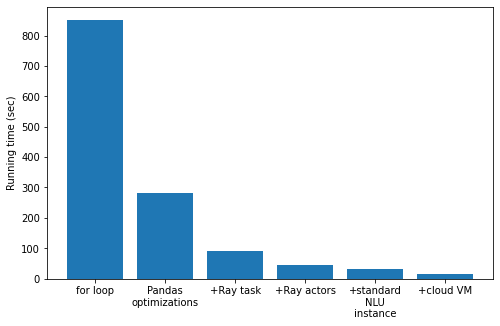

In [30]:
import matplotlib.pyplot as plt
time_data = {
    # All times in seconds
    "for loop": 852,
    "Pandas\noptimizations": 283,
    "+Ray task": 90,
    "+Ray actors": 45, 
    "+standard\nNLU\ninstance": 30,   
    # Separate run on IBM Cloud machine with 56 cores.
    "+cloud VM": 15,
}

plt.figure(figsize=(8, 5))
plt.bar(time_data.keys(), time_data.values())
plt.ylabel("Running time (sec)")
plt.show()

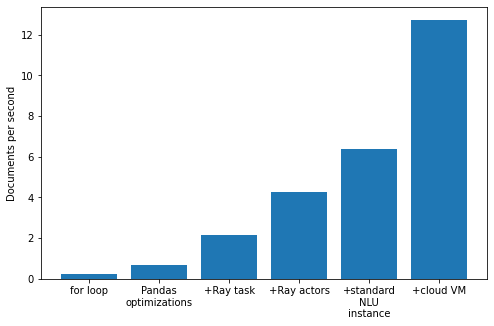

In [32]:
# The previous chart, but comparing documents per second
num_docs = len(articles.index)
docs_per_sec = {
    k: num_docs/v for k, v in time_data.items()
}
plt.figure(figsize=(8, 5))
plt.bar(docs_per_sec.keys(), docs_per_sec.values())
plt.ylabel("Documents per second")
plt.show()